In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from matplotlib import pyplot

In [2]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])


In [3]:
def example_of_usage():
    future_num_predic_steps = 1
    past_steps_to_use = 4
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays((arr, arr2), past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps_to_use +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2 12]
  [ 3 13]
  [ 4 14]
  [ 5 15]]

 [[ 3 13]
  [ 4 14]
  [ 5 15]
  [ 6 16]]

 [[ 4 14]
  [ 5 15]
  [ 6 16]
  [ 7 17]]

 [[ 5 15]
  [ 6 16]
  [ 7 17]
  [ 8 18]]

 [[ 6 16]
  [ 7 17]
  [ 8 18]
  [ 9 19]]]
[[116]
 [117]
 [118]
 [119]
 [120]]
(5, 4, 2)
(5, 1)


In [4]:
filename_asoc = "../data/grouped_data_day_mean_tweets_sentimentdata-scraper_asociaciones_2016-2020.csv"
filename_ibex ="../data/grouped_data_day_mean_tweets_sentimentdata-scraper_ibex_2018-2020.csv"
filename_ibex_prices ="../data/ibex_historico.csv"
filename_precios_bolsa = "../data/es_mse_mean_day.csv"

df_asoc = pd.read_csv(filename_asoc, sep=";")
df_ibex = pd.read_csv(filename_ibex, sep=";")
df_ibex_prices = pd.read_csv(filename_ibex_prices, sep=",")
df_precios_bolsa = pd.read_csv(filename_precios_bolsa, sep=";")

df_x = pd.merge(left=df_asoc, right=df_ibex, left_on='normalised_date', right_on='normalised_date')
df_total = pd.merge(left=df_x, right=df_ibex_prices, left_on='normalised_date', right_on='Date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_ibex"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_ibex", "Close"]]

df_precios_bolsa = df_precios_bolsa[["date", "price_change"]]
df_precios_bolsa["date"]= pd.to_datetime(df_precios_bolsa["date"]) 
df_total = pd.merge(left=df_total, right=df_precios_bolsa, left_on='normalised_date', right_on='date')

df_total.sentiment_asociacones = df_total.sentiment_asociacones.diff()
df_total.sentiment_ibex = df_total.sentiment_ibex.diff()
df_total.Close = df_total.Close.diff()
df_total = df_total.dropna()
df_total = df_total.rename(columns={"Close": "ibex_change", "price_change": "madrid_change"})
df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float)
df_total['sentiment_ibex'] = df_total['sentiment_ibex'].astype(float)
df_total['ibex_change'] = df_total['ibex_change'].astype(float)
df_total['madrid_change'] = df_total['madrid_change'].astype(float)

df_total = df_total[:-100]

df_total


,normalised_date,sentiment_asociacones,sentiment_ibex,ibex_change,date,madrid_change
1,2017-01-24,0.031742,-0.000420,82.400390,2017-01-24,1.260981
2,2017-01-25,-0.007774,-0.432036,162.099610,2017-01-25,1.614972
3,2017-01-26,-0.038962,0.479446,-36.500000,2017-01-26,-0.810021
4,2017-01-27,0.046862,-0.417707,-8.700196,2017-01-27,-0.140292
5,2017-01-30,-0.008826,0.478613,-142.799804,2017-01-30,-1.385265
...,...,...,...,...,...,...
741,2019-12-17,-0.021648,-0.018915,-64.699218,2019-12-17,-0.553620
742,2019-12-18,0.049066,0.003646,5.899414,2019-12-18,-0.258039
743,2019-12-19,-0.009887,-0.003893,-4.599610,2019-12-19,-0.007002
744,2019-12-20,0.090181,0.017316,58.299805,2019-12-20,0.090962


In [6]:

num_steps = 7
future_steps = 1
X_sent_asoc = df_total["sentiment_asociacones"].values[:-future_steps]
X_sent_ibex = df_total["sentiment_ibex"].values[:-future_steps]
X_ibex_prices = df_total["ibex_change"].values[:-future_steps]
X_madrid_prices = df_total["madrid_change"].values[:-future_steps]
X_madrid_prices_next = df_total["madrid_change"].values

X = np.array(create_window_data_arrays((X_sent_asoc, X_sent_ibex, X_ibex_prices,X_madrid_prices), num_steps))
#X = np.array(create_window_data_arrays((X_sent_asoc, X_sent_ibex), num_steps))
Y = create_window_data_array_with_shift(X_madrid_prices_next,future_steps, num_steps +future_steps)
print(X.shape, Y.shape)

(737, 7, 4) (737, 1)


In [7]:
train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.1, shuffle=False)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(663, 7, 4) (663, 1) (74, 7, 4) (74, 1)


 - loss: 0.6992 - accuracy: 0.0000e+00 - val_loss: 0.5996 - val_accuracy: 0.0000e+00
Epoch 68/250
17/17 - 0s - loss: 0.6943 - accuracy: 0.0000e+00 - val_loss: 0.6003 - val_accuracy: 0.0000e+00
Epoch 69/250
17/17 - 0s - loss: 0.6996 - accuracy: 0.0000e+00 - val_loss: 0.6004 - val_accuracy: 0.0000e+00
Epoch 70/250
17/17 - 0s - loss: 0.6943 - accuracy: 0.0000e+00 - val_loss: 0.6008 - val_accuracy: 0.0000e+00
Epoch 71/250
17/17 - 0s - loss: 0.7052 - accuracy: 0.0000e+00 - val_loss: 0.6002 - val_accuracy: 0.0000e+00
Epoch 72/250
17/17 - 0s - loss: 0.6984 - accuracy: 0.0000e+00 - val_loss: 0.6007 - val_accuracy: 0.0000e+00
Epoch 73/250
17/17 - 0s - loss: 0.7020 - accuracy: 0.0000e+00 - val_loss: 0.6007 - val_accuracy: 0.0000e+00
Epoch 74/250
17/17 - 0s - loss: 0.7040 - accuracy: 0.0000e+00 - val_loss: 0.6006 - val_accuracy: 0.0000e+00
Epoch 75/250
17/17 - 0s - loss: 0.6973 - accuracy: 0.0000e+00 - val_loss: 0.6004 - val_accuracy: 0.0000e+00
Epoch 76/250
17/17 - 0s - loss: 0.6955 - accuracy: 

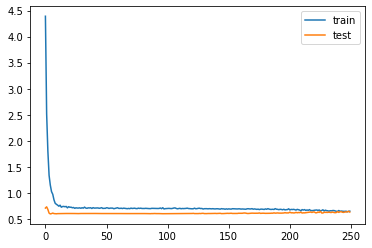

In [8]:
output_size = future_steps
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.7))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

 - val_mae: 0.6291
Epoch 59/200
16/16 - 0s - loss: 0.7020 - accuracy: 0.0000e+00 - mae: 0.7020 - val_loss: 0.6291 - val_accuracy: 0.0000e+00 - val_mae: 0.6291
Epoch 60/200
16/16 - 0s - loss: 0.7018 - accuracy: 0.0000e+00 - mae: 0.7018 - val_loss: 0.6291 - val_accuracy: 0.0000e+00 - val_mae: 0.6291
Epoch 61/200
16/16 - 0s - loss: 0.7024 - accuracy: 0.0000e+00 - mae: 0.7024 - val_loss: 0.6291 - val_accuracy: 0.0000e+00 - val_mae: 0.6291
Epoch 62/200
16/16 - 0s - loss: 0.7022 - accuracy: 0.0000e+00 - mae: 0.7022 - val_loss: 0.6291 - val_accuracy: 0.0000e+00 - val_mae: 0.6291
Epoch 63/200
16/16 - 0s - loss: 0.7021 - accuracy: 0.0000e+00 - mae: 0.7021 - val_loss: 0.6290 - val_accuracy: 0.0000e+00 - val_mae: 0.6290
Epoch 64/200
16/16 - 0s - loss: 0.7020 - accuracy: 0.0000e+00 - mae: 0.7020 - val_loss: 0.6290 - val_accuracy: 0.0000e+00 - val_mae: 0.6290
Epoch 65/200
16/16 - 0s - loss: 0.7020 - accuracy: 0.0000e+00 - mae: 0.7020 - val_loss: 0.6290 - val_accuracy: 0.0000e+00 - val_mae: 0.6290
E

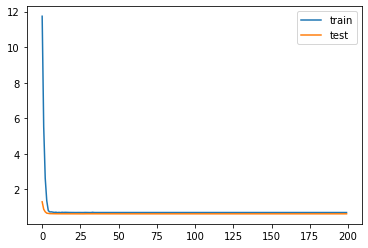

In [35]:
output_size = future_steps
n_timesteps = train_X.shape[1]
n_features = train_X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.7))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

2/2 [==============================] - 0s 3ms/step
0.6292409815185482
[[-5.37282007e-01 -6.24160208e-02]
 [ 8.17110222e-01 -1.55179724e-01]
 [ 7.78123932e-01 -4.52983007e-02]
 [-1.51659280e+00 -5.38632907e-02]
 [ 1.56726091e-02 -1.32375985e-01]
 [ 2.37036356e-01 -6.49157688e-02]
 [ 9.81716730e-01 -1.58040952e-02]
 [ 1.41691892e-01 -6.24645762e-02]
 [-1.24991572e+00 -1.11787081e-01]
 [ 4.74965562e-01 -7.84589723e-02]
 [-1.03694218e+00 -2.67775115e-02]
 [ 2.74535272e-01 -8.45567062e-02]
 [ 7.30343929e-01 -4.58920794e-03]
 [ 2.94466056e-01 -1.31195551e-03]
 [-5.60131152e-01  1.81050058e-02]
 [-2.56899406e+00  1.10485051e-02]
 [ 7.72556855e-02 -3.86752486e-02]
 [ 6.73011065e-01 -1.52341470e-01]
 [ 8.47009896e-01 -2.26332337e-01]
 [-1.32753686e+00 -3.38796198e-01]
 [ 6.98783723e-01  1.28532220e-02]
 [ 1.59029434e+00  3.00508924e-04]
 [ 2.14353386e+00  1.77996177e-02]
 [-5.13868912e-01 -7.81764612e-02]
 [ 1.14559500e+00 -1.75672010e-01]
 [ 8.67808424e-01 -4.43009287e-02]
 [-1.25999514e-01  3

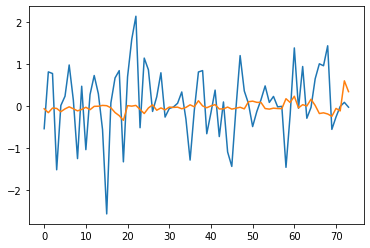

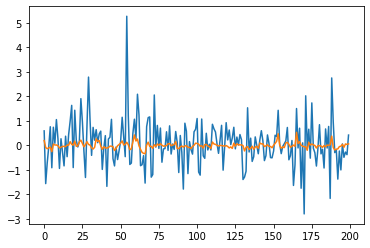

In [13]:
#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred))

M = np.column_stack((test_y, y_pred))
#M_untransformed = scaler.inverse_transform(M)

#y_pred_un = scaler.inverse_transform(y_pred.reshape((len(y_pred),1)))
#test_y_un = scaler.inverse_transform(test_y.reshape((len(test_y),1)))

print(M)


print("---")
#print(M_untransformed)

#print(df_total.values[-3:])


def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = model.predict(X, batch_size=40, verbose=1)
print("----")
print(mean_absolute_error(Y, y_pred))
print("----")

print(mean_absolute_percentage_error(y_pred,Y))


y_pred_test = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred_test))
print(r2_score(y_pred_test,test_y))
print(mean_absolute_percentage_error(test_y,y_pred_test))

M = np.column_stack((test_y, y_pred_test))
plot1 = plt.figure(2)
plt.plot(M)

y_pred_train = model.predict(train_X, batch_size=40, verbose=1)
print(mean_absolute_error(train_y, y_pred_train))
print(r2_score(y_pred_train,train_y))
print(mean_absolute_percentage_error(train_y,y_pred_train))

M = np.column_stack((Y, y_pred))

plot1 = plt.figure(3)
plt.plot(M[:200])

plt.show()


In [10]:
def take_predecesor(y):
    y_pred = y[:-1]
    y_pred = np.insert(y_pred, 0, 0, axis=0)
    return y_pred

Y_null_model = take_predecesor(Y)

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795  0.        ]
 [-1.56814621  0.58604795]
 [-0.7183444  -1.56814621]
 [-0.05927397 -0.7183444 ]
 [ 0.75498299 -0.05927397]
 [-0.92035478  0.75498299]
 [ 0.73546661 -0.92035478]
 [ 0.08049359  0.73546661]
 [ 1.04769402  0.08049359]
 [ 0.27684574  1.04769402]]
1.1543982682410578
-1.0332154827669124
inf


In [11]:
predecesor_1 = take_predecesor(Y)
predecesor_2 = take_predecesor(predecesor_1)

Y_null_model = (predecesor_1 + predecesor_2)/2

M=np.column_stack((Y, Y_null_model))
print(M[:10])
print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795  0.        ]
 [-1.56814621  0.29302398]
 [-0.7183444  -0.49104913]
 [-0.05927397 -1.14324531]
 [ 0.75498299 -0.38880918]
 [-0.92035478  0.34785451]
 [ 0.73546661 -0.08268589]
 [ 0.08049359 -0.09244408]
 [ 1.04769402  0.4079801 ]
 [ 0.27684574  0.56409381]]
0.9818592538167107
-1.7468596427928431
inf


In [12]:
mean = np.mean(Y)
Y_null_model = np.full(Y.shape, mean)
np.column_stack((Y, Y_null_model))

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795 -0.03544755]
 [-1.56814621 -0.03544755]
 [-0.7183444  -0.03544755]
 [-0.05927397 -0.03544755]
 [ 0.75498299 -0.03544755]
 [-0.92035478 -0.03544755]
 [ 0.73546661 -0.03544755]
 [ 0.08049359 -0.03544755]
 [ 1.04769402 -0.03544755]
 [ 0.27684574 -0.03544755]]
0.8188123962996046
-3.300079309257901e+34
2309.926728590984
